CS244 Assignment 6 - Group 8
===============

* Kevin Rothi (leader)
* John Lanier
* J.Y. Ku

Github Repository 
https://github.com/JBLanier/cs244fall2017/ 


Our team initially beleived that we were supposed to train a classifier based on both Accelerometer and PPG data. After two unsuccessful attempts to construct training datasets (They were both too noisy for classification based on PPG readings), we were unsure how to proceed. After learning that classification was to be based on on accelerometer readings, we were relieved, and acheived good results. 


### Changes to Server code:
We made a new GET handler at [http://myserveris.online/hw6raw_csv](http://myserveris.online/hw6raw_csv) This returns a csv of the last 30,000 recorded samples (10 minutes at 50Hz) of raw ppg and accelerometer data.

This endpoint may or may not be active at the time of reading as we sometimes wipe our server data when debugging.


### Changes to Board code:
Our board already uploads ppg and accelerometer data at a near continous rate. Early on, we found that with several optimizations, we can efficiently send every 50 samples to the server with a trassmission time of roughly 40 - 80 milliseconds depending on the network conditions. This results in an average sample rate of roughly 46 Hz. While transmitting our samples each paired with unix timestampes, we have found that a 46 Hz sample rate with no noticable hiccups in the data is better than the alternative of a perfect 50 Hz rate with occasional bad breaks in the sampling stream to make large network communications.

We were incorrectly using the FIFO queue for PPG readings, resulting in a sample and hold behavior (every 3 or so samples would be the same value). The FIFO queue is no longer used in favor of getting immediate readings. This bug was fixed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn
np.random.seed(42)
%matplotlib inline

# Activity Classification

Classification using accelerometer data went without a hitch. We didn't use raw x,y,z data as features because we reasoned that the orientation of the device is generally not indicative of the activity, and training a classifier on such data would result in overfitting. 

Instead, we use the mean total magnitude of the acceleration within discrete windows as well as the standard deviation of the magnitude in those windows. There two features yielded a fairly separable distribution between activities.

Finally, our features were scaled to help our linear classifier.

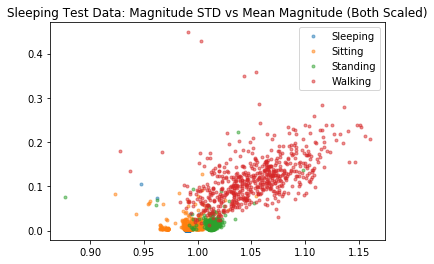

Cross Validation Accuracy: 0.8679166666666667
Test Error Rate on a 2nd 10 minute sleeping data set: 0.023333333333333317


In [11]:
def getGeneratedFeatureData(raw_data, window_size):
    gen_features = np.full(((len(raw_data)//window_size),3),-1.0)
    for window_num, window_start_index in enumerate(range(0,len(raw_data),window_size)):
        # Check for case in which last window isn't as large as desired window_size
        if (window_start_index + window_size) > len(raw_data):
            #print("Last window at {} was too small, excluding it.".format(window_start_index))
            break
        # Gather magnitudes of data points in window
        window_magnitudes = np.full(window_size,-1.0)
        for window_index, raw_data_index in enumerate(range(window_start_index, window_start_index + window_size)):
            magnitude = np.linalg.norm(raw_data[raw_data_index][-4:-1])
            window_magnitudes[window_index] = magnitude 
            #print("c: {} index: {} W: {} values: {} magnitude: {}".format(raw_data[raw_data_index,-1],raw_data_index,window_num,raw_data[raw_data_index][:-1],magnitude))
       
        #print("Window:\n{}".format(window_magnitudes))
        #print("Mean: {} Std: {}".format(window_magnitudes.mean(),window_magnitudes.std()))
        gen_features[window_num,0] = window_magnitudes.mean()
        gen_features[window_num,1] = window_magnitudes.std()
        gen_features[window_num,2] = raw_data[0,-1]
    return gen_features

# Pull in Raw Training Data
tr_sleeping = np.genfromtxt('sleeping.csv', delimiter=',')[1:]
tr_sitting = np.genfromtxt('sitting.csv', delimiter=',')[1:]
tr_standing = np.genfromtxt('standing.csv', delimiter=',')[1:]
tr_walking = np.genfromtxt('walking.csv', delimiter=',')[1:]

# Add Class Labels
tr_sleeping = np.concatenate((tr_sleeping,np.full((len(tr_sleeping),1),1)),axis=1)
tr_sitting  = np.concatenate((tr_sitting ,np.full((len(tr_sitting) ,1),2)),axis=1)
tr_standing = np.concatenate((tr_standing,np.full((len(tr_standing),1),3)),axis=1)
tr_walking  = np.concatenate((tr_walking ,np.full((len(tr_walking) ,1),4)),axis=1)

# Trim out all but xyz and class data
tr_sleeping = tr_sleeping[:,-4:]
tr_sitting = tr_sitting[:,-4:]
tr_standing = tr_standing[:,-4:]
tr_walking = tr_walking[:,-4:]

# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude only)
window_size = 50
tr_sleeping = getGeneratedFeatureData(tr_sleeping,window_size)
tr_sitting = getGeneratedFeatureData(tr_sitting,window_size)
tr_standing = getGeneratedFeatureData(tr_standing,window_size)
tr_walking = getGeneratedFeatureData(tr_walking,window_size)

# Put Training data in one np array
train = np.concatenate((tr_sleeping,tr_sitting,tr_standing,tr_walking))

tr_X = train[:,:-1]
tr_Y = train[:,-1]

# Scale the data
scaler = StandardScaler()
scaler.fit(tr_X)
tr_X = scaler.transform(tr_X)

# Plot
df = pd.DataFrame(train)
df.columns = ['Mean', 'STD', 'Class']
groups = df.groupby('Class')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for group, label in zip(groups,['Sleeping','Sitting','Standing','Walking']):
    group = group[1]
    ax.plot(group.Mean, group.STD, marker='o', alpha = 0.5, linestyle='', ms=3, label=label)
ax.legend()
plt.title("Sleeping Test Data: Magnitude STD vs Mean Magnitude (Both Scaled)")
plt.show()

# Cross Validate on an SVM
clf = svm.SVC()
scores = cross_val_score(clf, tr_X, tr_Y, cv=5)
print('Cross Validation Accuracy: {}'.format(np.mean(scores)))

# Evaluate test performance on 10 minutes of sleeping
clf.fit(tr_X,tr_Y)

test_sleeping = np.genfromtxt('sleeping2.csv', delimiter=',')[1:]
test_sleeping = np.concatenate((test_sleeping,np.full((len(test_sleeping),1),1)),axis=1)
test_sleeping = test_sleeping[:,-4:]
test_sleeping = getGeneratedFeatureData(test_sleeping,window_size)
test_sleeping_X = test_sleeping
test_X = test_sleeping[:,:-1]
test_X = scaler.transform(test_X)
test_Y = test_sleeping[:,-1]

test_accuracy = sklearn.metrics.accuracy_score(test_Y,clf.predict(test_X))
test_error_rate = 1.0 - test_accuracy

print("Test Error Rate on a 2nd 10 minute sleeping data set: {}".format(test_error_rate))


In the graph above, sleeping (blue) falls into a tiny spot in the bottom center, where the user is for the most part not moving.
Our cross validation accuracy as well as our testing accuracy on 10 minutes of sleeping (different from the sleeping training set, obviously) was satisfactory. 

# Vital Signs Calculation

Our methods from assignment 3 had to be redone to fair well with real world data. Filter parameters needed adjustment, and windowing methods were also adopted to reduce error due to any noise that may have made it through the filtering process.

Our PPG sensor's original mount placed the sensor about 1cm from the user's finger. This resulted in a constant unusable amount of noise, and a new mount had to be constucted to press the user's finger against the sensor. It produces much better data, but still suffers from inhibiting levels of noise when motion is present.

Our new ppg mount:
![sensor1](https://jblanier.xyz/media/hw6_1.jpg)
![sensor1](https://jblanier.xyz/media/hw6_2.jpg)

Below are some convenience functions we made for the heavy lifting done beyond this cell.

In [3]:
def getRatio(acRed, dcIR, acIR, dcRed):
    return float(acRed * dcIR) / (acIR * dcRed)

def calculateSPO2(R):
    return (-45.060 * math.pow(R, 2)) + (30.354 * R) + 94.845

def generateWindow(index, window_size_seconds, Fs):
    return index, index + (window_size_seconds * int(Fs))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, [high], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

Our data for sleeping is quit nice looking even when unfiltered. In more motion-filled activities, noise is a big problem, and changes must be made to the PPG recording process to prevent trash in/trash out for activities like standing and walking.

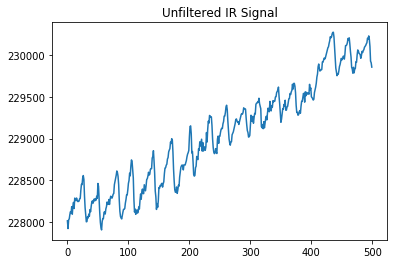

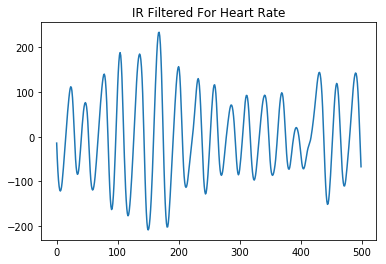

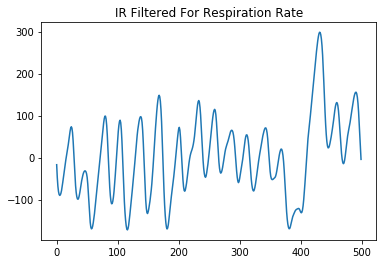

In [4]:
sensor_data = np.genfromtxt('sleeping2.csv', delimiter=',')[1:] #pull in the data from the csv (generates matrix)

time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
time = time - time.min()

ir = sensor_data[:,1]
red = sensor_data[:,2]

Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
Ts = 1.0/Fs # sampling interval

#Cutoff frequencies in Hz
heart_rate_lowcut = 0.8
heart_rate_highcut = 1.8

respiration_lowcut = 0.2
respiration_highcut = 1.5

#filter data
filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)

plt.plot(ir[50:550])
plt.title("Unfiltered IR Signal")
plt.show()

plt.plot(filtered_heart_rate_ir[50:550])
plt.title("IR Filtered For Heart Rate")
plt.show()

plt.plot(filtered_respiration_ir[50:550])
plt.title("IR Filtered For Respiration Rate")
plt.show()

## Heart Rate and Respiration Rate Calculations

For both heart rate and respiration rate, we calculated the distances between peaks to get frequencies. Favoring accuracy over time granularity, our final ouputs are the average rates calculated over every 10 peaks. For charting purposes, every final output reading has an associated timestamp marking the beginning of the time window that it represents.

In [5]:
hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=30)[0] 
rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

hr_window_size = 10
heartRates = np.zeros(len(hrPeaks))
heartRateTimeStampes = np.zeros(len(hrPeaks)//hr_window_size)
print('---------- HR VALUES -----------')
heartRates = np.zeros(len(hrPeaks))
for peakIndex in range(len(hrPeaks) - 1):
    if (peakIndex % hr_window_size) == 0 and peakIndex + hr_window_size < len(hrPeaks):
        heartRateTimeStampes[peakIndex//hr_window_size] = time[hrPeaks[peakIndex]]
        
    distance = time[hrPeaks[peakIndex + 1]] - time[hrPeaks[peakIndex]]
    heartRates[peakIndex] = (60000 / distance)
if not len(heartRates) % hr_window_size == 0:
    heartRates = heartRates[:-(len(heartRates) % hr_window_size)]
heartRates = np.mean(heartRates.reshape(-1, hr_window_size),axis=1)
for r in heartRates:
    print(r)
print('Mean: {}'.format(np.array(heartRates).mean()))
print('---------- END HR VALUES ---------------')


rr_window_size = 10
rRates = np.zeros(len(rrPeaks))
rRateTimeStampes = np.zeros(len(rrPeaks)//rr_window_size)
print('---------- RR VALUES -----------')
for peakIndex in range(len(rrPeaks) - 1):
    if (peakIndex % rr_window_size) == 0 and peakIndex + rr_window_size < len(rrPeaks):
        rRateTimeStampes[peakIndex//rr_window_size] = time[rrPeaks[peakIndex]]
    
    distance = time[rrPeaks[peakIndex + 1]] - time[rrPeaks[peakIndex]]
    rRates[peakIndex] = (60000 / distance)
if not len(rRates) % rr_window_size == 0:
    rRates = rRates[:-(len(rRates) % rr_window_size)]
rRates = np.mean(rRates.reshape(-1, rr_window_size),axis=1)
for r in rRates:
    print(r)
print('Mean: {}'.format(np.array(rRates).mean()))
print('---------- END RR VALUES ---------------')

---------- HR VALUES -----------
44.4835658303
39.9220904904
67.3246940833
51.8912162514
61.2081087138
70.1958083933
62.9736216615
71.3971246613
60.6645492112
62.5027392655
66.4288855729
64.8926312119
68.6575853423
61.9675734689
55.9475665961
61.6085641801
58.0455275437
67.2440849837
53.0669474086
62.8048991845
46.2767561446
50.9936110099
58.0510208933
53.3898595663
60.1185055355
62.6619017949
64.1314201237
62.5152731562
51.3603831737
55.8194416301
64.1263678203
62.704611139
62.8824686058
68.2785472643
63.3180135237
55.9718600239
58.5670011041
56.9598333259
59.0345604847
66.0372121217
55.5541585802
58.9222124298
61.2270880682
52.3523084198
60.0184653176
50.9114293906
53.5931226276
47.3409549717
53.042491339
57.2635007832
61.9276736649
48.297817363
55.9872982222
55.2261519024
39.7247508734
43.2731561203
Mean: 58.05516093874894
---------- END HR VALUES ---------------
---------- RR VALUES -----------
14.389421515
15.9560232499
16.071026909
15.8395705619
13.0044682099
15.2961993534
16.269

## SPO2 Calculations
A big challenge associated with getting accurate SPO2 readings is reliable peak detection. In this assignment, our team explored a new approach to detecting peaks in a windowed segment of IR and RED data for the purpose of calculating the SPO2 level. The issue with our previous methodology is that the periodicity of the signal we wished to perform peak detection on was variable, so no single value for the order parameter of scipy.signal.argrelextrema worked for all instances. What we do now is first try to do peak detection with a value for order that works reasonable well. If we detect that that value failed to give us good peak detection, the algorithm will start with small values for the order and incrementally increase it, checking with each iteration to evaluate the result. This technique was much more reliable than our previous attempt, which would just try the most generalizable value and record the result, even if peak detection was not successful. This approach will still fail if the signal is so noisy that SPO2 can’t be extracted from the signal. We observed this behavior in the data we collected for the walking activity, but for the sleeping activity this new approach was far more reliable.

In [6]:

#--------------------
#---- SPO2 Calc -----
#--------------------

spo2_window_size_seconds = 3

ir_spo2 = np.reshape(ir, len(ir))
red_spo2 = np.reshape(red, len(red))  # shape them

b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
filtIR = signal.filtfilt(b, a, ir_spo2, method='gust') #using filtfilt to avoid phase shift
filtRed = signal.filtfilt(b, a, red_spo2, method='gust') 

redDC = [] # need relevant arrays
redAC = []
irDC = []
irAC = []
spo2_timestamps = []

index = 0
while True:
    lb, ub = generateWindow(index, spo2_window_size_seconds, Fs) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if (ub > len(ir)):
        break
    redSlice = filtRed[lb:ub]
    irSlice = filtIR[lb:ub] #filtered data
    valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
    peaks = signal.argrelmax(redSlice, order=10)[0]
    valley1 = valleys[0] + lb
    valley2 = valleys[1] + lb
    peak = peaks[0] + lb
    if (peak < valley1): #to make sure the peak is between the valleys
        peak = peaks[1] + lb
    dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
    dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
    testSPO2 = calculateSPO2(getRatio(filtRed[peak] - dcred, dcir, filtIR[peak] - dcir, dcred))
    if testSPO2 < 96.0 or testSPO2 > 99.9: # garbage value? let's try searching for peaks dynamically
        attempts = 0
        while (testSPO2 < 96.0 or testSPO2 > 99.9) and attempts < 14 : # try orders from 6 - 19
            valleys = signal.argrelmin(redSlice, order=6 + attempts)[0] #find peaks and valleys
            peaks = signal.argrelmax(redSlice, order=6 + attempts)[0]
            if (len(valleys) < 2 or len(peaks) < 2):
                break; # no peaks or valleys?
            valley1 = valleys[0] + lb
            valley2 = valleys[1] + lb
            peak = peaks[0] + lb
            if (peak < valley1): #to make sure the peak is between the valleys
                peak = peaks[1] + lb
            dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
            dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
            attempts = attempts + 1
    irDC += [dcir]
    irAC += [filtIR[peak] - dcir]
    redDC += [dcred]
    redAC += [filtRed[peak] - dcred]
    spo2_timestamps.append(time[index])
    
    index = ub
        
    
print('---------- SPO2 VALUES -----------')
spo2s = []
for iteration in range(len(redDC)):
    spo2s.append(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
    print(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
print('Mean: {}'.format(np.array(spo2s).mean()))
print('---------- END SPO2 VALUES -----------')


---------- SPO2 VALUES -----------
97.2695659738
93.7212539843
96.4132611682
90.7391020359
96.2433678428
90.2595996
91.1944005731
92.9487180072
95.2502398404
94.9234389935
92.6370267036
96.3284696692
96.2418086307
97.8410129002
91.156898487
96.6350274654
96.8720741699
96.8534587711
93.0683247678
98.2947749367
96.3085387726
90.4000576593
99.2091056211
97.3146920459
98.7162958155
91.5347295897
97.7415283948
96.1673053121
97.76993573
97.5587827249
98.7396405959
98.0900937114
97.0488485116
97.5473525817
98.5876397363
95.7740905087
96.1327925234
94.0489448103
96.2863979682
97.7132044122
97.1040129159
96.8879263371
97.7514321995
98.0816030122
95.7171278004
96.0543184654
93.43817513
98.2858742449
98.2078082452
98.2265500437
94.815456152
96.9742323259
98.0609797509
97.9597170882
95.7168736562
96.4716186547
99.0430372889
95.8890165573
95.7322556288
93.0075065369
97.4244446089
93.4833840694
97.0250450145
94.9732927833
93.9577583548
97.9661251223
98.7315243612
97.1809329284
95.9469688386
97.32156

### Plot of SPO2, Heart Rate, and Respiration Rate over the course of the dataset:

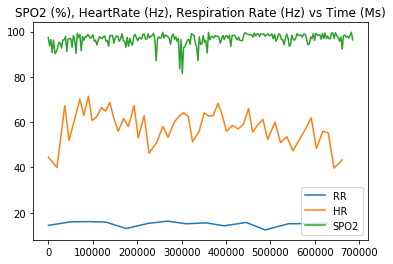

In [9]:
plt.plot(rRateTimeStampes,rRates,label="RR")
plt.plot(heartRateTimeStampes,heartRates,label="HR")
plt.plot(spo2_timestamps, spo2s,label="SPO2")
plt.legend()
plt.title("SPO2 (%), HeartRate (Hz), Respiration Rate (Hz) vs Time (Ms)")
plt.show()

Here we export requested values to a csv:

In [8]:
d = {'IR': pd.Series(ir),
     'RED': pd.Series(red),
     'X': pd.Series(sensor_data[:,3]),
     'Y': pd.Series(sensor_data[:,4]),
     'Z': pd.Series(sensor_data[:,5]),
     'HR': pd.Series(heartRates),
     'RR': pd.Series(rRates),
     'SPO2': pd.Series(spo2s),
     'Error Rate': pd.Series(test_error_rate)
    }

export_df = pd.DataFrame(d)
export_df = export_df[['IR','RED','X','Y','Z','HR','RR','SPO2','Error Rate']]

export_df.to_csv('team8_assignment6.csv', index=False)